In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

In [2]:
train = pd.read_csv('data/train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.isna().sum() / len(train) * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [6]:
round(train.isna().sum() / len(train), 4) * 100

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

In [7]:
[(i, train[i].unique()) if train[i].nunique() <= 10 else (i, train[i].nunique()) for i in train.columns]

[('PassengerId', 891),
 ('Survived', array([0, 1], dtype=int64)),
 ('Pclass', array([3, 1, 2], dtype=int64)),
 ('Name', 891),
 ('Sex', array(['male', 'female'], dtype=object)),
 ('Age', 88),
 ('SibSp', array([1, 0, 3, 4, 2, 5, 8], dtype=int64)),
 ('Parch', array([0, 1, 2, 5, 3, 4, 6], dtype=int64)),
 ('Ticket', 681),
 ('Fare', 248),
 ('Cabin', 147),
 ('Embarked', array(['S', 'C', 'Q', nan], dtype=object))]

<Axes: ylabel='Frequency'>

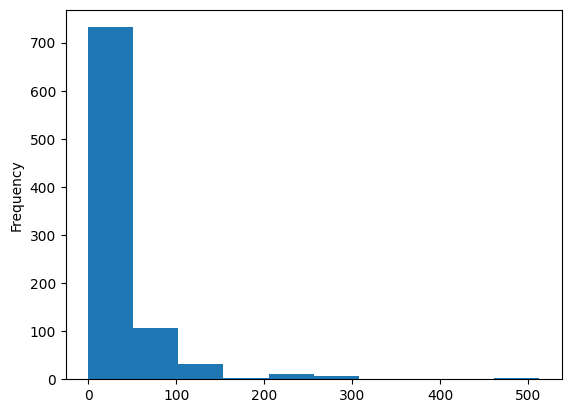

In [8]:
train.Fare.plot(kind='hist')

In [9]:
# train = train[train.Fare < 100]

In [10]:
X_train = train.drop('Survived', axis=1)
y_train = train.Survived

In [11]:
class modifyColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        
        X_new['Cabin'] = X_new.Cabin.str[0]
        # X_new['Ticket'] = X_new.Ticket.str[0]
        X_new['FamilyMember'] = X_new.SibSp + X_new.Parch
        X_new['IsAlone'] = X_new.FamilyMember.apply(lambda x: True if x == 0 else False)

        salute = ['Sir. ', 'Miss. ', 'Mr. ', 'Mrs. ']

        for i in salute:
            X_new[i] = X_new.Name.str.contains(i) == True

        # X_new.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
        X_new.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
        
        return X_new

In [12]:
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  
])

In [13]:
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [14]:
numerical_cols = [i for i in modifyColumns().transform(X_train) if modifyColumns().transform(X_train)[i].dtype == 'float64']
categorical_cols = [i for i in modifyColumns().transform(X_train) if modifyColumns().transform(X_train)[i].dtype != 'float64']

In [15]:
numerical_cols, categorical_cols

(['Age', 'Fare'],
 ['Pclass',
  'Sex',
  'SibSp',
  'Parch',
  'Cabin',
  'Embarked',
  'FamilyMember',
  'IsAlone',
  'Sir. ',
  'Miss. ',
  'Mr. ',
  'Mrs. '])

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols), 
        ('cat', categorical_transformer, categorical_cols)  
    ]
)

In [17]:
pipeline = Pipeline([
    ('modifyColumns', modifyColumns()),
    ('preprocessor', preprocessor),
    ('clf', SVC())
])

In [18]:
modifyColumns().transform(X_train).head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,FamilyMember,IsAlone,Sir.,Miss.,Mr.,Mrs.
0,3,male,22.0,1,0,7.2500,NaN,S,1,False,False,False,True,False
1,1,female,38.0,1,0,71.2833,C,C,1,False,False,False,False,True
2,3,female,26.0,0,0,7.9250,NaN,S,0,True,False,True,False,False
3,1,female,35.0,1,0,53.1000,C,S,1,False,False,False,False,True
4,3,male,35.0,0,0,8.0500,NaN,S,0,True,False,False,True,False


In [ ]:
# acc -> 0.8361308141359614
# kaggle score -> 

# Best parameters found:  {'clf': <catboost.core.CatBoostClassifier object at 0x000001F9E10AEAD0>, 'clf__bagging_temperature': 0, 'clf__depth': 6, 'clf__iterations': 1000, 'clf__l2_leaf_reg': 1, 'clf__learning_rate': 0.01}

In [19]:
# param_grid = {'clf': [CatBoostClassifier(verbose=False), SVC(), RandomForestClassifier(), SGDClassifier(), LogisticRegression()]}

param_grid = [
    {
        'clf': [CatBoostClassifier(verbose=False)],
        'clf__learning_rate': [0.01, 0.1],  
        'clf__depth': [6, 8],               
        'clf__iterations': [500, 1000],     
        'clf__l2_leaf_reg': [1, 5],         
        'clf__bagging_temperature': [0, 0.5]  
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'clf': <catboost.core.CatBoostClassifier object at 0x000001B64DAE0210>, 'clf__bagging_temperature': 0, 'clf__depth': 6, 'clf__iterations': 1000, 'clf__l2_leaf_reg': 1, 'clf__learning_rate': 0.01}
Best cross-validation score:  0.8361308141359614


In [20]:
test = pd.read_csv('data/test.csv')

In [21]:
best_model = grid_search.best_estimator_

y_test = best_model.predict(test)

print("Predictions: ", y_test)

Predictions:  [0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 1 0 1 0 0 1]


In [22]:
result = pd.DataFrame(y_test, columns=['Survived'])

In [23]:
test.join(result)[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)